<a href="https://colab.research.google.com/github/SupermarketAutomationAI/baseline_model_SVM/blob/main/baseline_model_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading, Splitting, and Preprocessing

In [1]:
import os
import json
import math
import shutil
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.models
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.metrics import confusion_matrix

#from models import *
#from utils import *
import sys, datetime, random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.patches as patches
from PIL import Image

import tensorflow as tf
import torchvision.transforms as T
import cv2


# imports
from sklearn import svm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Load the Data

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! rm -rf /root/datasets/V3_combined_all_DS/
# ! rm -rf /root/datasets/

In [ ]:
# import zipfile
# Hooman + co
# ! unzip -uq '/content/drive/MyDrive/APS360 Project/Dataset Zip Files/V3_combined_all_DS.zip' -d '/root/datasets/'

# Jane
! unzip '/content/drive/MyDrive/APS360/V3_combined_all_DS-1' -d '/root/datasets/'

In [2]:
# Clean the data, remove the metadate image files, marked with "._" in names
parent_dir = "/root/datasets/V3_combined_all_DS"

classes = ['Bananas', 'Carambola', 'Fuji Apples', 'Gala Apples', 'Golden Delicious Apples', 
           'Granny Smith Apples', 'Guava', 'Kiwi', 'Mango', 'Muskmelon', 'Oranges', 'Peach', 
           'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red Delicious Apples', 
           'Tomatoes']

for cat in classes:
    path = parent_dir + '/' + cat
    invalid_files = glob(os.path.join(path,"._*"))
    for file_ in invalid_files:
        os.remove(file_)
    invalid_files = glob(os.path.join(path," ._*"))
    for file_ in invalid_files:
        os.remove(file_)
    print("Deleted image metadata files from {}".format(path))

## Split the data

In [4]:
# create data directory and move all images into it
parent_dir = "/root/datasets/V3_combined_all_DS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [6]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)

## Preprocess data into Dataloaders

In [7]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/V3_combined_all_DS/train
Deleted ._* files from /root/datasets/V3_combined_all_DS/val
Deleted ._* files from /root/datasets/V3_combined_all_DS/test


In [3]:
# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# define a list of all classes that the model will be trained with

# List different classes: 19 currently
classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Orange', 
           'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
           'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']

data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), 
                                        transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  26966
Amount of validation data:  8966
Amount of test data:  8939


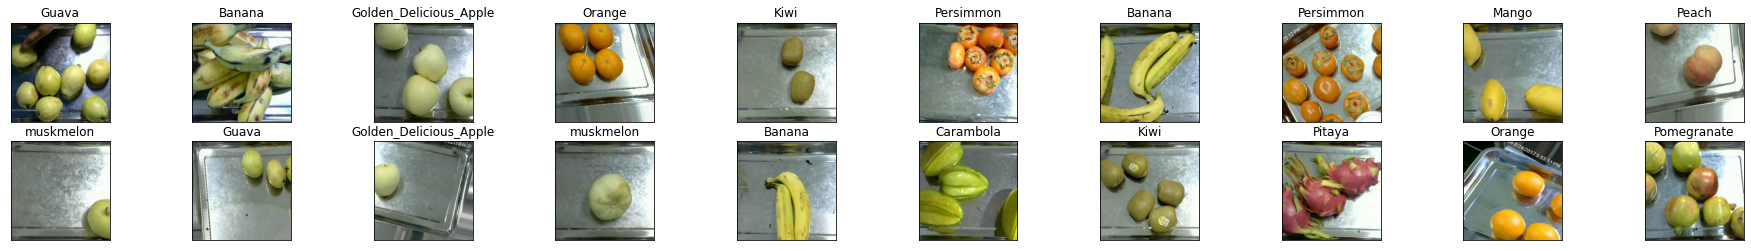

In [11]:
# View 20 random, post processed, training images
fig = plt.figure(figsize=(32, 4)) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

n=1
for data in iter(train_loader):
  img,label = data
  if n <= 20:
    image = img.numpy()
    ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    ax.set_title(classes[label])
    n = n+1
  else:
    break

In [6]:
# set the batch_size
batch_size = 64

# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')


# three possible transforms, will test each to see which gives better results
data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_data.__len__())
val_loader = torch.utils.data.DataLoader(val_data, batch_size=val_data.__len__())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_data.__len__())

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  26966
Amount of validation data:  8966
Amount of test data:  8939


# Model Building, Training, and Testing

In [6]:
import random
def data_augmentation(img):
  '''
  Perform one of the following data augmentation techniques on the image
  Input img is expected to be a tensor
  Output is also a tensor
  '''
  aug_img = img
  #random.seed(1000)
  val = random.randint(0,5)
  if val is 0:
    aug_img = transforms.functional.gaussian_blur(img=img, kernel_size=13)
  elif val is 1:
    aug_img = transforms.functional.adjust_contrast(img=img, contrast_factor=0.55)
  elif val is 2:
    aug_img = transforms.functional.adjust_contrast(img=img, contrast_factor=1.55)
  elif val is 3:
    aug_img = transforms.functional.adjust_brightness(img=img, brightness_factor=0.45)
  elif val is 4:
    aug_img = transforms.functional.adjust_brightness(img=img, brightness_factor=1.66)
  elif val is 5:
    aug_img = transforms.functional.adjust_saturation(img=img, saturation_factor=0.55)
  #else return same image
  return aug_img

In [10]:
alexnet = torchvision.models.alexnet(pretrained=True)

In [8]:
# save features with Alexnet
def get_alexnet_features(path, output_path, group, classes, data_aug=True, verify=False):
  '''
  path is where the images are
  output_path is where to store them
  group is [train, val, test]
  verify will show some sample output of images
  '''
  start_time = time.time()
  sc = StandardScaler()
  pca = decomposition.PCA(n_components=1)

  # ensure output path exists
  if os.path.exists(output_path) is False:
    os.mkdir(output_path)

  data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

  dataset = datasets.ImageFolder(os.path.join(path, group), transform=data_CC_transform)

  # load data with batch size of 1 since each image needs to be saved 1 at a time
  batch_size = 1
  num_workers = 1
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, shuffle=True)

  feature_path = os.path.join(output_path, group)
  print("Features saved to {}.".format(feature_path))
  if os.path.exists(feature_path):
    # may contain old data
    shutil.rmtree(feature_path)
    print("Found {} removed.".format(feature_path))
  os.mkdir(feature_path)

  n = 0
  fig = plt.figure(figsize=(32, 4)) #for verify later on
  print("Saving data features...")
  for img, label in loader: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = os.path.join(feature_path, str(classes[label]))
    if os.path.isdir(folder_name) is False:
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

    if data_aug is True:
      aug_img = data_augmentation(img)
      aug_features = alexnet.features(aug_img)
      aug_features_tensor = torch.from_numpy(aug_features.detach().numpy())
      torch.save(aug_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

    if verify is True and n <= 20:
      # verification step
      image = img.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[label[0]])

      # for augmented image
      if data_aug is True:
        aug_image = aug_img.numpy()
        ax = fig.add_subplot(2, 20/2, n-1, xticks=[], yticks=[])
        plt.imshow(np.transpose(aug_image[0], (1, 2, 0)))
        ax.set_title(classes[label[0]])

  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return

In [11]:
feature_dir = "/root/datasets/features"
get_alexnet_features(parent_dir, output_path=feature_dir, group="train", classes=classes, data_aug=False, verify=False)

Features saved to /root/datasets/features/train.
Found /root/datasets/features/train removed.
Saving data features...
Total time:   864.35 s


<Figure size 2304x288 with 0 Axes>

Features saved to /root/datasets/features/val.
Saving data features...
Total time:   561.54 s
Features saved to /root/datasets/features/test.
Saving data features...
Total time:   515.78 s


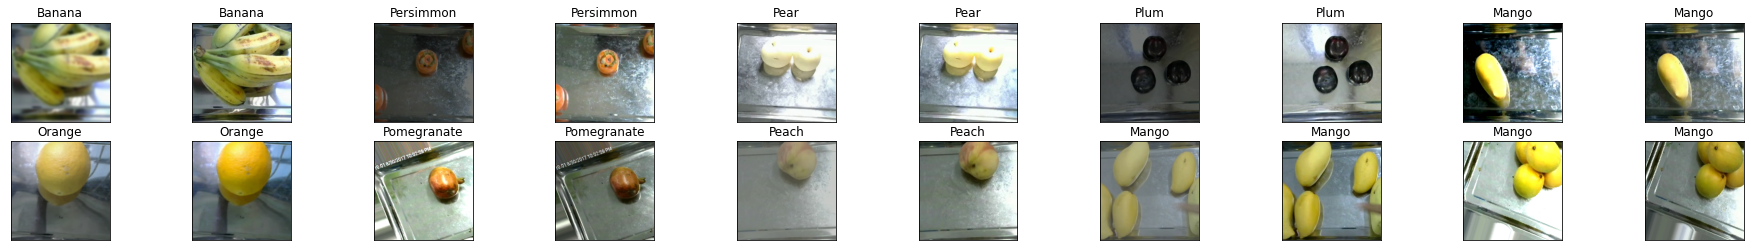

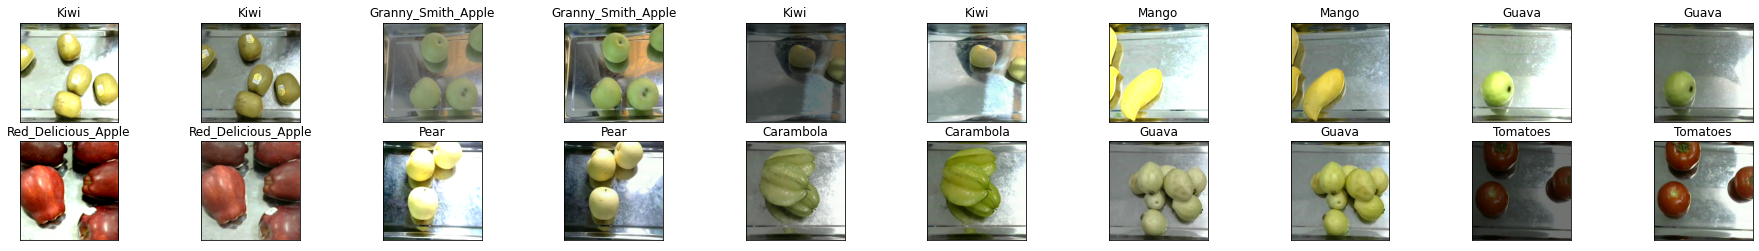

In [21]:
get_alexnet_features(parent_dir, output_path="/root/datasets/features", group="val", classes=classes, data_aug=True, verify=False)
get_alexnet_features(parent_dir, output_path="/root/datasets/features", group="test", classes=classes, data_aug=True, verify=False)

In [5]:
def get_data_loader(path, batch_size=32, verify=True):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    train_dataset = torchvision.datasets.DatasetFolder(path + '/train', loader=torch.load, extensions=('.tensor'))
    val_dataset = torchvision.datasets.DatasetFolder(path + '/val', loader=torch.load, extensions=('.tensor'))
    test_dataset = torchvision.datasets.DatasetFolder(path + '/test', loader=torch.load, extensions=('.tensor'))

    # # Prepare Dataloader
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_dataset.__len__(),
                                             num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_dataset.__len__(),
                                             num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.__len__(),
                                             num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    if verify is True:
      data_iter = iter(train_loader)
      features, labels = data_iter.next()
      print("Training Shape:")
      print(features.shape)
      print(labels.shape)

    return train_loader, val_loader, test_loader
    # return None, None, None

In [28]:
def get_accuracy(model, d_loader):
    dataiter = iter(d_loader)
    images, labels = dataiter.next()

    scaling = MinMaxScaler(feature_range=(-1,1)).fit(images)
    images = scaling.transform(images)
    
    images = images.reshape(images.shape[0], -1)
    acc = model.score(images, labels)
    return acc

In [12]:
train_feature_loader, val_features_loader, test_feature_loader = get_data_loader(feature_dir, batch_size=64, verify=True)

Training Shape:
torch.Size([26966, 256, 6, 6])
torch.Size([26966])


In [43]:
dataiter = iter(train_feature_loader)
images, labels = dataiter.next()

sc = StandardScaler()
pca = decomposition.PCA(n_components=10)

images = images.view(images.shape[0], -1)
images = sc.fit_transform(images)
features = pca.fit_transform(images)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(features)
features = scaling.transform(features)

clf = svm.SVC(kernel='poly')

clf.fit(features, labels)
# training accuracy
print(clf.score(features, labels))

0.8123933842616629


In [44]:
# validation accuracy
dataiter = iter(val_features_loader)
images, labels = dataiter.next()

images = images.view(images.shape[0], -1)
images = sc.transform(images)
features = pca.transform(images)
features = scaling.transform(features)

val_acc = clf.score(features, labels)
print(val_acc)

0.6445460629043052


In [ ]:
#https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [21]:

def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    #pred_class = [FRUIT_RECOG_CATEGORY_NAMESV2[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    #pred_class = pred_class[:pred_t+1]
    return pred_boxes#, pred_class

In [ ]:
def object_detection_api(img_path, model, classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=1):
  boxes = get_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    out = model(features)
    print(out)
    pred_class = out.max(1, keepdim=True)[1]
    print(pred_class)
    cv2.putText(img,classes[pred_class[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [51]:
def object_detection_api_clf(img_path, model, classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=1):
  boxes = get_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    features = features.detach().numpy()

    features = torch.Tensor(features).view(1, -1)
    features = features.view(features.shape[0], -1)

    features = sc.transform(features)
    features = pca.transform(features)
    features = scaling.transform(features)

    out = clf.predict(features)
    print(out)
    cv2.putText(img,classes[out[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

[9]
[9]


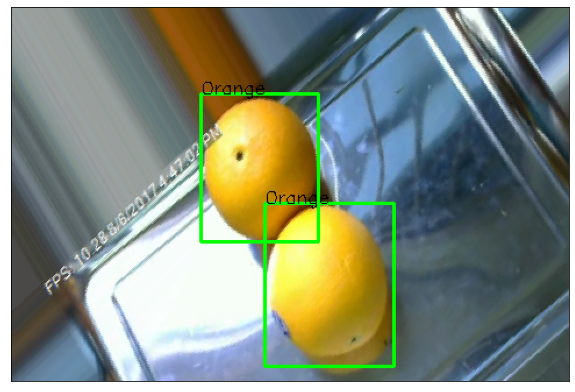

In [56]:
# img_path = "/root/datasets/V2_combinedDS/train/Red_Delicious_Apple/107Red Delicious Apple 01001107.png"

# img_path = "/root/datasets/V3_combined_all_DS/val/Granny_Smith_Apple/Granny Smith Apple 00151.png"
img_path = "/root/datasets/V3_combined_all_DS/test/Orange/Orange00102.png"

object_detection_api_clf(img_path, clf, classes=classes, threshold=0.8)